In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/denoising-dirty-documents/sampleSubmission.csv
/kaggle/input/denoising-dirty-documents/train_cleaned/173.png
/kaggle/input/denoising-dirty-documents/train_cleaned/38.png
/kaggle/input/denoising-dirty-documents/train_cleaned/5.png
/kaggle/input/denoising-dirty-documents/train_cleaned/146.png
/kaggle/input/denoising-dirty-documents/train_cleaned/138.png
/kaggle/input/denoising-dirty-documents/train_cleaned/215.png
/kaggle/input/denoising-dirty-documents/train_cleaned/201.png
/kaggle/input/denoising-dirty-documents/train_cleaned/81.png
/kaggle/input/denoising-dirty-documents/train_cleaned/161.png
/kaggle/input/denoising-dirty-documents/train_cleaned/83.png
/kaggle/input/denoising-dirty-documents/train_cleaned/129.png
/kaggle/input/denoising-dirty-documents/train_cleaned/20.png
/kaggle/input/denoising-dirty-documents/train_cleaned/170.png
/kaggle/input/denoising-dirty-documents/train_cleaned/68.png
/kaggle/input/denoising-dirty-documents/train_cleaned/89.png
/kaggle/input/den

* Importing the required libraries

In [2]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

from keras.preprocessing import image
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Activation, BatchNormalization, Flatten, Conv2D, Input
from keras.layers import MaxPooling2D, Dropout, UpSampling2D

Using TensorFlow backend.


In [3]:
%matplotlib inline

(420, 540)


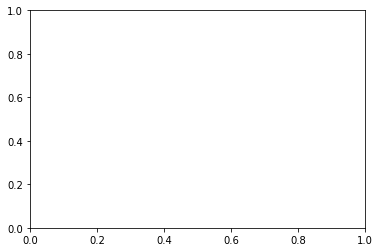

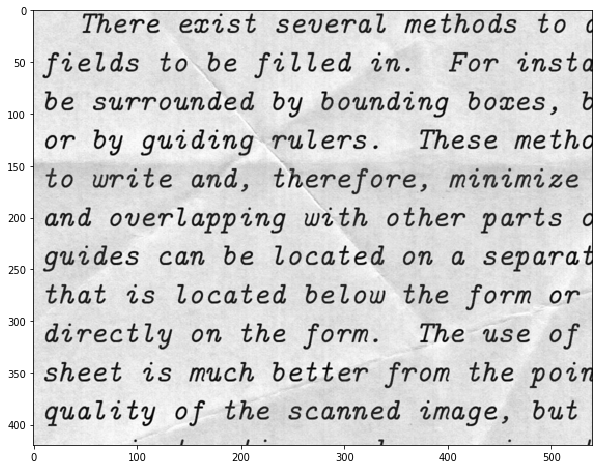

In [4]:
f, ax= plt.subplots()
plt.figure(figsize=(20,8))
img= cv2.imread("../input/denoising-dirty-documents/train/125.png",0)
plt.imshow(img, cmap="gray")
print(img.shape)

In [5]:
TRAIN_IMAGE= glob.glob("../input/denoising-dirty-documents/train/*.png")
CLEAN_TR_IMAGE= glob.glob("../input/denoising-dirty-documents/train_cleaned/*.png")
TEST_IMAGE= glob.glob("../input/denoising-dirty-documents/test/*.png")

* Loading the images

In [6]:
def load_image(path):
    image_list= np.zeros((len(path), 258,540,1))
    for i, fig in enumerate(path):
        img= image.load_img(fig, color_mode="grayscale", target_size=(258,540,1))
        x= image.img_to_array(img).astype("float32")
        x=x/255.0
        image_list[i]=x
    return(image_list)
                  

In [7]:
x_train= load_image(TRAIN_IMAGE)
c_image= load_image(CLEAN_TR_IMAGE)
x_test= load_image(TEST_IMAGE)

In [8]:
# Printing out the shape of the image data
print(x_train.shape)
print(c_image.shape)
print(x_test.shape)

(144, 258, 540, 1)
(144, 258, 540, 1)
(72, 258, 540, 1)


In [9]:
# Preparing the dataset for training and evaluation
def train_val_split(x_train, y_train):
    rnd = np.random.RandomState(seed=42)
    perm = rnd.permutation(len(x_train))
    train_idx = perm[:int(0.8 * len(x_train))]
    val_idx = perm[int(0.8 * len(x_train)):]
    return x_train[train_idx], y_train[train_idx], x_train[val_idx], y_train[val_idx]

x_train, y_train, x_val, y_val = train_val_split(x_train, c_image)
print(x_train.shape, x_val.shape)

(115, 258, 540, 1) (29, 258, 540, 1)


Down below we have the main class used for training the model.It has the following functions:
* Construct to initialize the necessart parameters.
* Function with model architecture.
* Function to train the model.
* Function to Evaluate the model

In [10]:
# Preparing the main class for training the model
class Autoencoder():
    def __init__(self):
        self.img_rows= 258
        self.img_cols= 540
        self.channels= 1
        self.img_shape= (self.img_rows, self.img_cols, self.channels)
        optimizer= Adam(lr= 0.001)
        self.autoencoder_model= self.build_model()
        self.autoencoder_model.compile(loss="mse", optimizer= optimizer)
        self.autoencoder_model.summary()
    # Function to build the model     
    def build_model(self):
        input_layer= Input(shape=self.img_shape)
        # Encoder
        h= Conv2D(64, (3,3), activation="relu", padding= "same")(input_layer)
        h= MaxPooling2D((2,2), padding="same")(h)
        # Decoder
        h= Conv2D(64, (3,3), activation="relu", padding="same")(h)
        h= UpSampling2D((2,2))(h)
        output_layer= Conv2D(1,(3,3), activation="sigmoid", padding="same")(h)
        return(Model(input_layer, output_layer))
    # Function to train the model on the data
    def train_model(self, x_train, y_train, x_val, y_val, epochs=60, batch_size= 20):
        early_stopping= EarlyStopping(monitor="val_loss", min_delta=0, patience= 5, verbose=1, mode="auto")
        history= self.autoencoder_model.fit(x_train, y_train, batch_size=batch_size, epochs= epochs, validation_data=(x_val,y_val),callbacks=[early_stopping])
        # Plotting the training loss and the validation loss
        plt.plot(history.history["loss"])
        plt.plot(history.history["val_loss"])
        plt.title("MODEL LOSS")
        plt.ylabel("Loss")
        plt.xlabel("Epoch")
        plt.legend(["Train", "Test"], loc="upper left")
        plt.show()
    # Function to evaluate the model performance on the test data
    def eval_model(self, x_test):
        preds= self.autoencoder_model,predict(x_test)
        return(preds)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 258, 540, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 258, 540, 64)      640       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 129, 270, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 129, 270, 64)      36928     
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 258, 540, 64)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 258, 540, 1)       577       
Total params: 38,145
Trainable params: 38,145
Non-trainable params: 0
_______________________________________________________

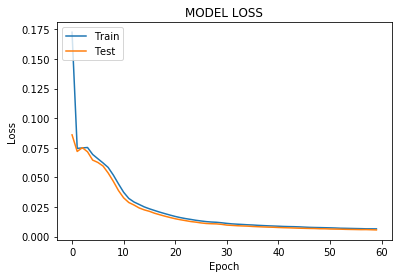

In [11]:
# Making the main class object
auto_encoder= Autoencoder()
# Calling the function to train the model
auto_encoder.train_model(x_train, y_train,x_val, y_val)

In [17]:
# Saving the model
auto_encoder.eval_model(x_train[1])

NameError: name 'predict' is not defined